# Report

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from helpers import filter_out_cate,visualize_data
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold

## Data cleaning

In [2]:
df2002_2018=pd.read_csv('data/2002-2018-property-sales-data.csv')
df_2019=pd.read_csv('data/2019-property-sales-data.csv')
df_2020=pd.read_csv('data/2020-property-sales-data.csv')
df_2021=pd.read_csv('data/2021-property-sales-data.csv')
df_2022=pd.read_csv('data/2022-property-sales-data.csv')

In [3]:
df2002_2018['covid_period']='no'
df_2019['covid_period']='no'
df_2020['covid_period']='yes'
df_2021['covid_period']='yes'
df_2022['covid_period']='yes'

In [4]:
combined_df = pd.concat([df2002_2018, df_2019, df_2020, df_2021, df_2022], ignore_index=True)
combined_df.columns

Index(['PropType', 'Taxkey', 'Address', 'CondoProject', 'District', 'Nbhd',
       'Style', 'Extwall', 'Stories', 'Year_Built', 'Nr_of_rms', 'Fin_sqft',
       'Units', 'Bdrms', 'Fbath', 'Hbath', 'Lotsize', 'Sale_date',
       'Sale_price', 'covid_period', 'PropertyID', 'taxkey', 'nbhd', 'Rooms',
       'FinishedSqft'],
      dtype='object')

In [5]:
combined_df.drop(columns=['taxkey', 'Address','PropertyID','Taxkey'], inplace=True)
combined_df.head()

,PropType,CondoProject,District,Nbhd,Style,Extwall,Stories,Year_Built,Nr_of_rms,Fin_sqft,...,Bdrms,Fbath,Hbath,Lotsize,Sale_date,Sale_price,covid_period,nbhd,Rooms,FinishedSqft
0,Commercial,NaN,6.0,6258.0,Commercial Exempt,NaN,2.0,1880.0,0.0,1840.0,...,0.0,0.0,0.0,12750,2002-01,15900,no,NaN,NaN,NaN
1,Commercial,NaN,3.0,6262.0,Mansions With Commercial Usage,NaN,2.0,1876.0,0.0,6377.0,...,0.0,0.0,0.0,11840,2002-01,850000,no,NaN,NaN,NaN
2,Commercial,NaN,10.0,6272.0,Service Building,NaN,1.0,1954.0,0.0,5022.0,...,0.0,0.0,0.0,9700,2002-01,119000,no,NaN,NaN,NaN
3,Commercial,NaN,1.0,6218.0,"Store Bldg - Multi Story (Store & Apt, Store & O",NaN,2.0,1955.0,0.0,6420.0,...,0.0,0.0,0.0,8792,2002-01,210000,no,NaN,NaN,NaN
4,Commercial,NaN,15.0,6254.0,"Store Bldg - Multi Story (Store & Apt, Store & O",NaN,2.0,1909.0,0.0,5956.0,...,0.0,0.0,0.0,4840,2002-01,48500,no,NaN,NaN,NaN


In [6]:
na_percentage = combined_df.isna().mean()
columns_to_keep = na_percentage <= 0.30
filtered_df = combined_df.loc[:, columns_to_keep]
filtered_df.columns

Index(['PropType', 'District', 'Style', 'Extwall', 'Stories', 'Year_Built',
       'Units', 'Bdrms', 'Fbath', 'Hbath', 'Lotsize', 'Sale_date',
       'Sale_price', 'covid_period'],
      dtype='object')

In [7]:
filtered_df.head()

,PropType,District,Style,Extwall,Stories,Year_Built,Units,Bdrms,Fbath,Hbath,Lotsize,Sale_date,Sale_price,covid_period
0,Commercial,6.0,Commercial Exempt,NaN,2.0,1880.0,1.0,0.0,0.0,0.0,12750,2002-01,15900,no
1,Commercial,3.0,Mansions With Commercial Usage,NaN,2.0,1876.0,1.0,0.0,0.0,0.0,11840,2002-01,850000,no
2,Commercial,10.0,Service Building,NaN,1.0,1954.0,1.0,0.0,0.0,0.0,9700,2002-01,119000,no
3,Commercial,1.0,"Store Bldg - Multi Story (Store & Apt, Store & O",NaN,2.0,1955.0,1.0,0.0,0.0,0.0,8792,2002-01,210000,no
4,Commercial,15.0,"Store Bldg - Multi Story (Store & Apt, Store & O",NaN,2.0,1909.0,1.0,0.0,0.0,0.0,4840,2002-01,48500,no


In [8]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60743 entries, 0 to 60742
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PropType      60730 non-null  object 
 1   District      60739 non-null  float64
 2   Style         60667 non-null  object 
 3   Extwall       47272 non-null  object 
 4   Stories       60612 non-null  float64
 5   Year_Built    60699 non-null  float64
 6   Units         60741 non-null  float64
 7   Bdrms         59471 non-null  float64
 8   Fbath         60086 non-null  float64
 9   Hbath         55901 non-null  float64
 10  Lotsize       60740 non-null  object 
 11  Sale_date     60741 non-null  object 
 12  Sale_price    60731 non-null  object 
 13  covid_period  60743 non-null  object 
dtypes: float64(7), object(7)
memory usage: 6.5+ MB


In [9]:
cols=['Style','Extwall']

for col in cols:
    filter_out_cate(filtered_df,col)

column needs to be removed
column needs to be removed


In [10]:
filtered_df.drop(columns=cols, inplace=True)
filtered_df.head()

/var/folders/fc/2czwg5s15mvc98ksz0lc2bz80000gn/T/ipykernel_8029/4011096178.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.drop(columns=cols, inplace=True)


,PropType,District,Stories,Year_Built,Units,Bdrms,Fbath,Hbath,Lotsize,Sale_date,Sale_price,covid_period
0,Commercial,6.0,2.0,1880.0,1.0,0.0,0.0,0.0,12750,2002-01,15900,no
1,Commercial,3.0,2.0,1876.0,1.0,0.0,0.0,0.0,11840,2002-01,850000,no
2,Commercial,10.0,1.0,1954.0,1.0,0.0,0.0,0.0,9700,2002-01,119000,no
3,Commercial,1.0,2.0,1955.0,1.0,0.0,0.0,0.0,8792,2002-01,210000,no
4,Commercial,15.0,2.0,1909.0,1.0,0.0,0.0,0.0,4840,2002-01,48500,no


In [11]:
residential_df = filtered_df.loc[filtered_df['PropType'] == 'Residential']

In [12]:
len(residential_df)

45635

In [13]:
residential_df.drop(columns=['PropType'], inplace=True)

/var/folders/fc/2czwg5s15mvc98ksz0lc2bz80000gn/T/ipykernel_8029/1723802993.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  residential_df.drop(columns=['PropType'], inplace=True)


In [14]:
residential_df = residential_df.dropna(subset=['Year_Built', 'Sale_price', 'Sale_date'])

residential_df['Sale_date'] = pd.to_datetime(residential_df['Sale_date'])

residential_df['Lotsize'] = residential_df['Lotsize'].str.replace(',', '').astype(float)

if residential_df['Sale_price'].dtype == 'object':
    residential_df['Sale_price'] = residential_df['Sale_price'].apply(
        lambda x: x.replace('$', '').replace(',', '') if isinstance(x, str) else x
    )
    residential_df['Sale_price'] = pd.to_numeric(residential_df['Sale_price'], errors='coerce')

residential_df = pd.get_dummies(residential_df, columns=['covid_period'])

for col in ['District', 'Stories', 'Units', 'Bdrms', 'Fbath', 'Hbath', 'Lotsize']:
    residential_df[col] = residential_df[col].fillna(residential_df[col].median())


In [15]:
residential_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45609 entries, 10 to 60736
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   District          45609 non-null  float64       
 1   Stories           45609 non-null  float64       
 2   Year_Built        45609 non-null  float64       
 3   Units             45609 non-null  float64       
 4   Bdrms             45609 non-null  float64       
 5   Fbath             45609 non-null  float64       
 6   Hbath             45609 non-null  float64       
 7   Lotsize           45609 non-null  float64       
 8   Sale_date         45609 non-null  datetime64[ns]
 9   Sale_price        45609 non-null  float64       
 10  covid_period_no   45609 non-null  uint8         
 11  covid_period_yes  45609 non-null  uint8         
dtypes: datetime64[ns](1), float64(9), uint8(2)
memory usage: 3.9 MB


In [16]:
residential_df.head()

,District,Stories,Year_Built,Units,Bdrms,Fbath,Hbath,Lotsize,Sale_date,Sale_price,covid_period_no,covid_period_yes
10,7.0,2.0,1913.0,4.0,9.0,1.0,0.0,5280.0,2002-02-01,42000.0,1,0
51,3.0,2.0,1897.0,4.0,2.0,2.0,0.0,5280.0,2002-05-01,145000.0,1,0
67,4.0,2.0,1907.0,6.0,0.0,1.0,0.0,5280.0,2002-06-01,30000.0,1,0
116,4.0,2.0,1890.0,4.0,4.0,1.0,0.0,5280.0,2002-10-01,66500.0,1,0
134,4.0,2.5,1891.0,2.0,7.0,6.0,0.0,5280.0,2002-11-01,150500.0,1,0


## Preliminary data visulization

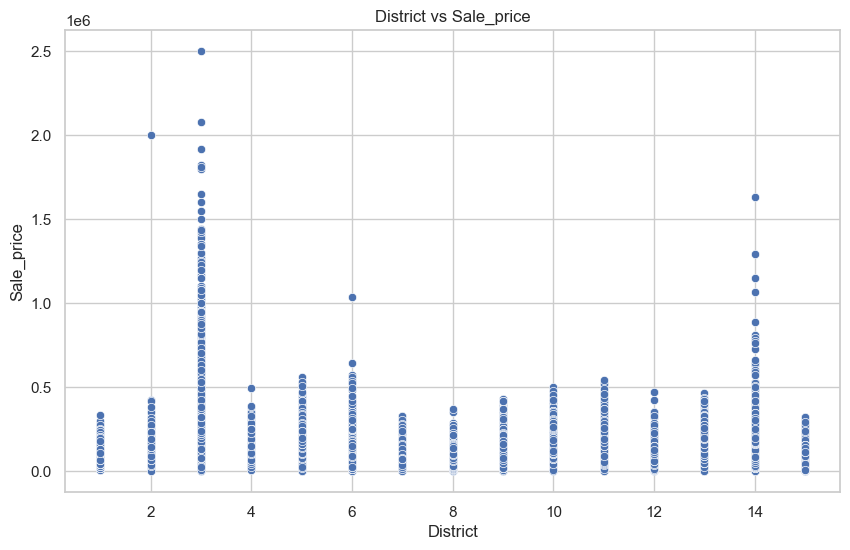

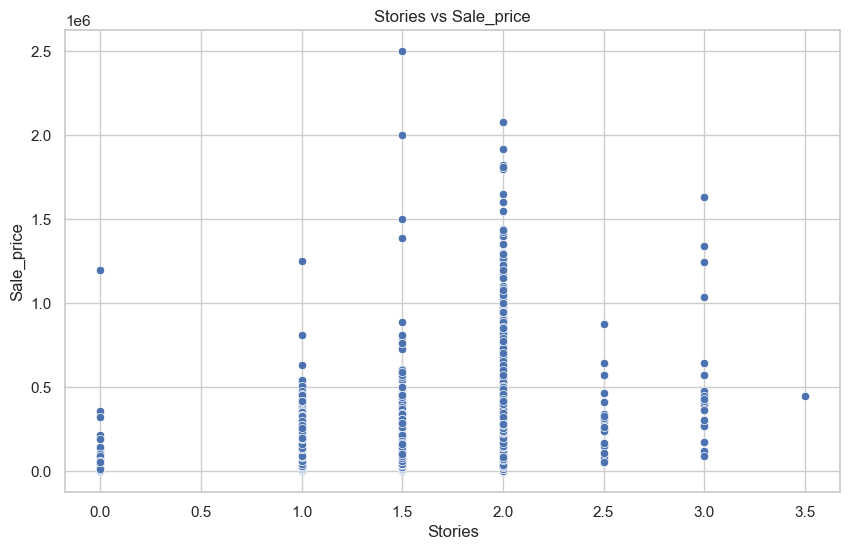

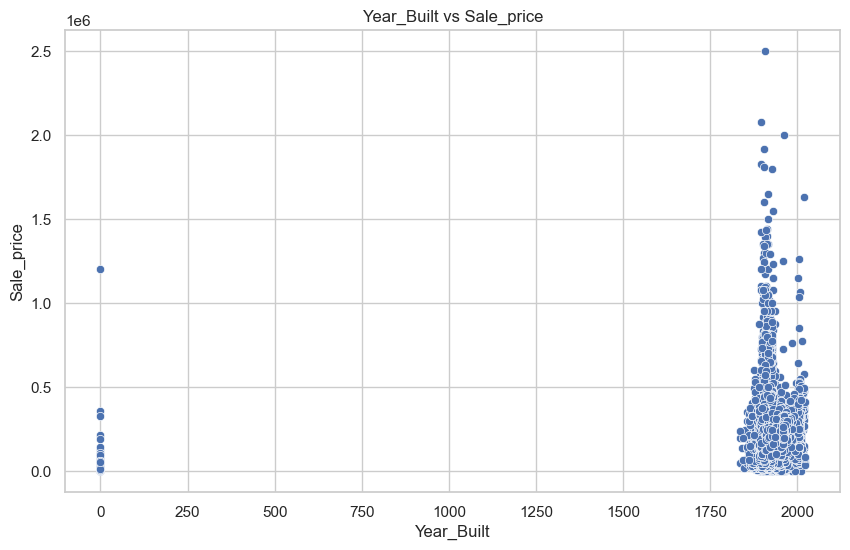

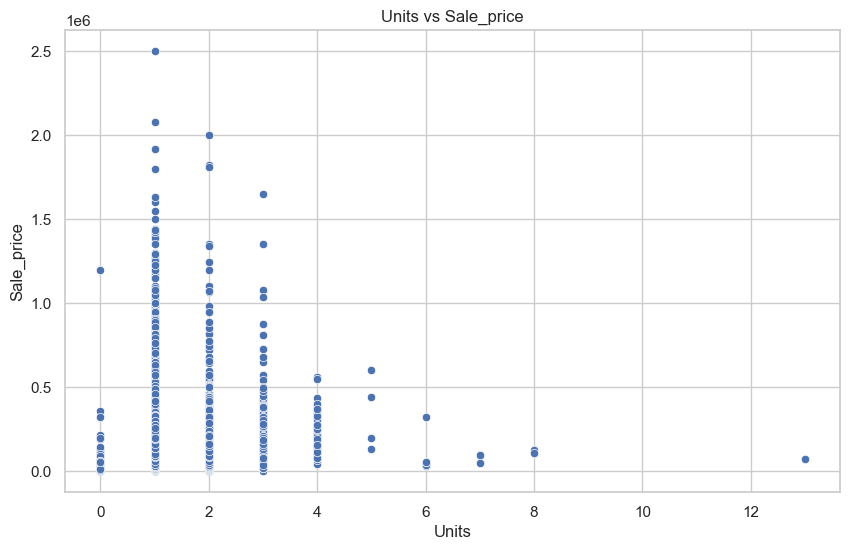

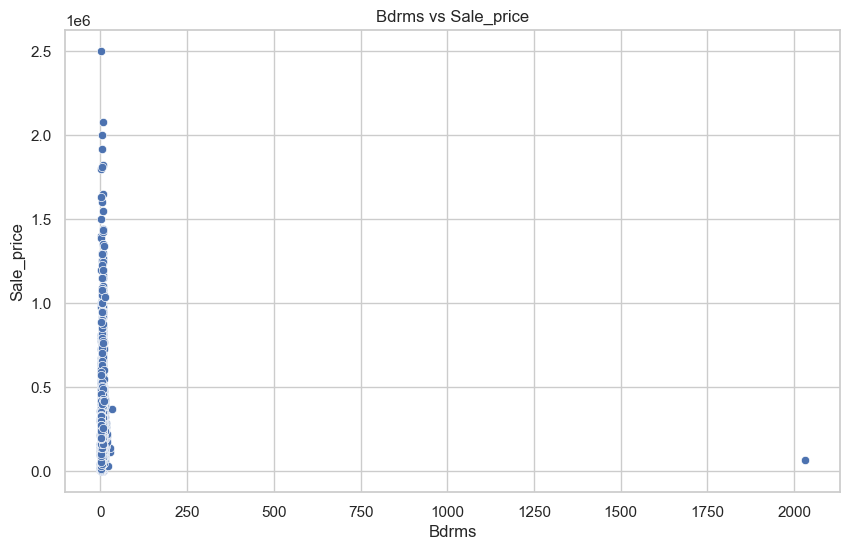

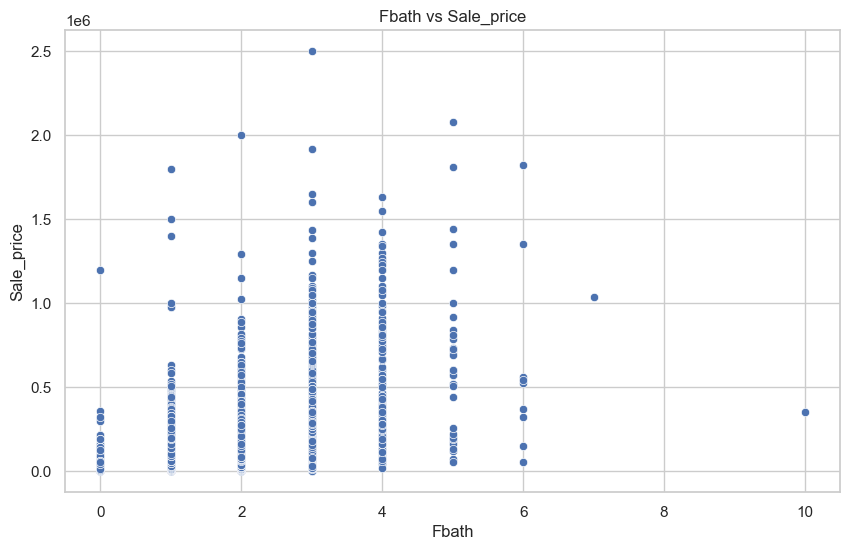

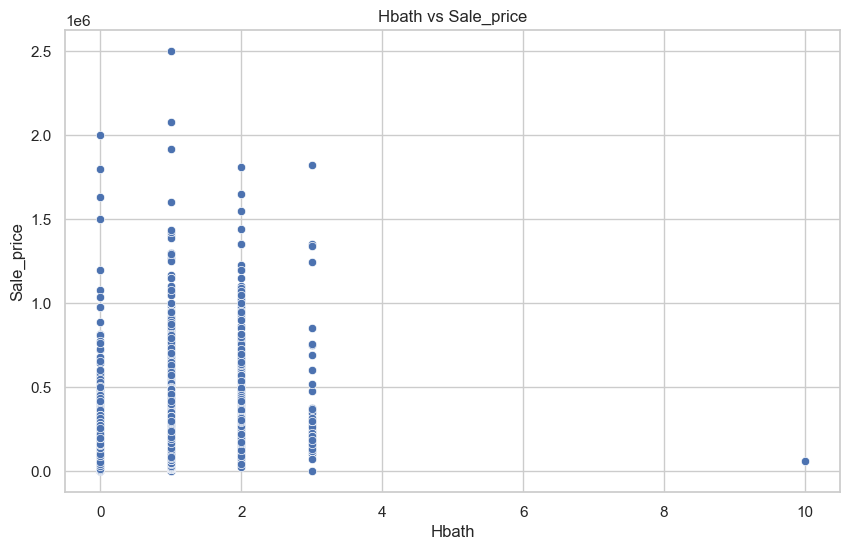

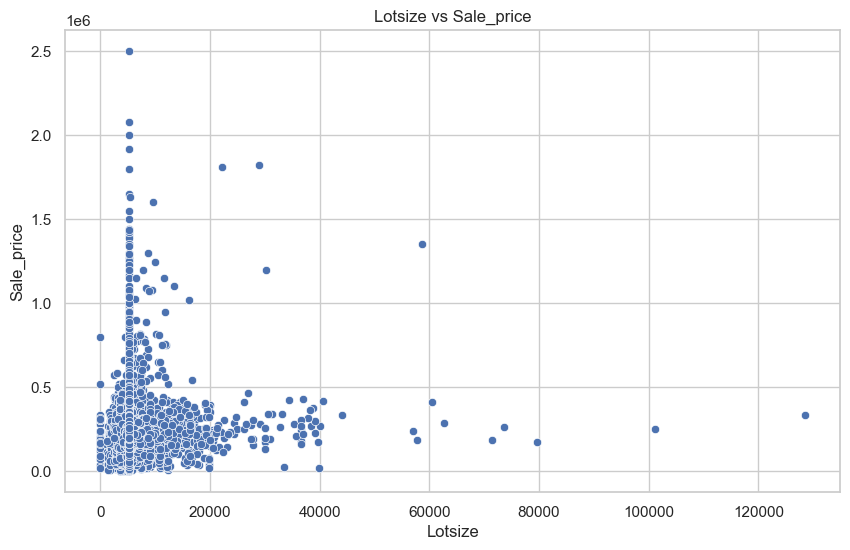

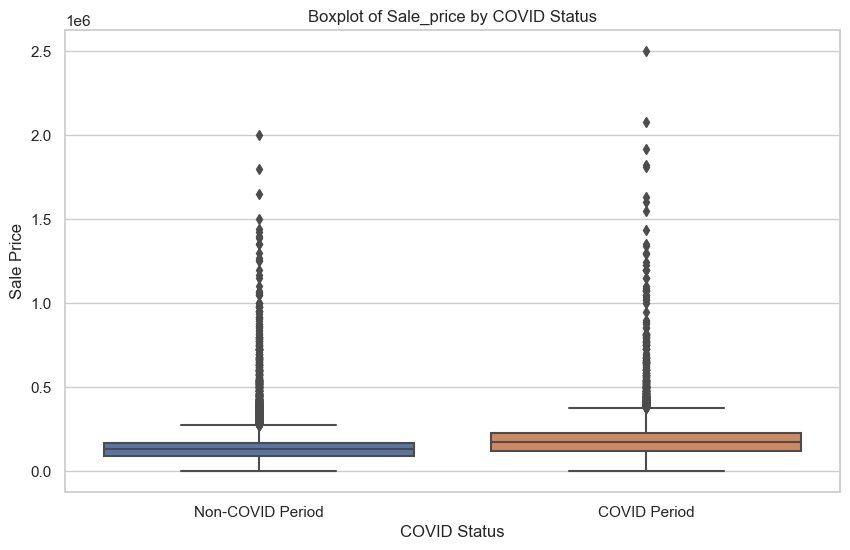

In [17]:
visualize_data(residential_df)

## Model training

In [ ]:
X = residential_df.drop(['Sale_price', 'COVID_Status'], axis=1) 
y = residential_df['Sale_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

### Random forest

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestRegressor(random_state=123)
rf_cv = GridSearchCV(estimator=rf, param_distributions=param_grid, cv=5, n_jobs=-1)
rf_cv.fit(X_train, y_train)
print("Best parameters found: ", rf_cv.best_params_)

### ANN 3 layers

In [ ]:
parameter_space_3_layer = {
    'hidden_layer_sizes': [(50, 50, 50), (50, 100, 50), (100, 50, 25)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant', 'adaptive'],
}


mlp_3_layer = MLPRegressor(max_iter=1000, random_state=123)


clf_3_layer = GridSearchCV(mlp_3_layer, parameter_space_3_layer, n_jobs=-1, cv=5)
clf_3_layer.fit(X_train, y_train)

print("Best parameters found for 3-layer MLP:", clf_3_layer.best_params_)

### ANN 2 layers

In [ ]:
parameter_space_2_layer = {
    'hidden_layer_sizes': [(50, 50), (100, 50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant', 'adaptive'],
}


mlp_2_layer = MLPRegressor(max_iter=1000, random_state=123)


clf_2_layer = GridSearchCV(mlp_2_layer, parameter_space_2_layer, n_jobs=-1, cv=5)
clf_2_layer.fit(X_train, y_train)


print("Best parameters found for 2-layer MLP:", clf_2_layer.best_params_)

### XGB

In [ ]:
xgb_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'colsample_bytree': [0.7, 1]
}

xgb = XGBRegressor(random_state=123)
xgb_cv = GridSearchCV(xgb, xgb_param_grid, cv=5, n_jobs=-1)
xgb_cv.fit(X_train, y_train)

print("Best parameters for XGBoost: ", xgb_cv.best_params_)

### ridge

In [ ]:
ridge_params = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
ridge = Ridge()
ridge_cv = GridSearchCV(ridge, ridge_params, cv=KFold(n_splits=5, shuffle=True, random_state=123))
ridge_cv.fit(X_train, y_train)
print("Best parameters for Ridge:", ridge_cv.best_params_)

### lasso

In [ ]:
lasso_params = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
lasso = Lasso()
lasso_cv = GridSearchCV(lasso, lasso_params, cv=KFold(n_splits=5, shuffle=True, random_state=123))
lasso_cv.fit(X_train, y_train)
print("Best parameters for Ridge:", lasso_cv.best_params_)

### ordinary least squares

In [ ]:
ols = LinearRegression()

### Cross validation

In [ ]:
rf_best = RandomForestRegressor(**rf_cv.best_params_, random_state=123)
ann_3_layer_best = MLPRegressor(**clf_3_layer.best_params_, random_state=123)
ann_2_layer_best = MLPRegressor(**clf_2_layer.best_params_, random_state=123)
xgb_best = XGBRegressor(**xgb_cv.best_params_, random_state=123)
ridge_best = Ridge(**ridge_cv.best_params_)
lasso_best = Lasso(**lasso_cv.best_params_)
ols = LinearRegression()  # OLS doesn't have hyperparameters

In [ ]:
from sklearn.model_selection import cross_val_score, KFold
import numpy as np


cv = KFold(n_splits=5, shuffle=True, random_state=123)
models = [rf_best, ann_3_layer_best, ann_2_layer_best, xgb_best, ridge_best, lasso_best, ols]
model_names = ['Random Forest', 'ANN 3 Layer', 'ANN 2 Layer', 'XGBoost', 'Ridge', 'Lasso', 'OLS']

for model, name in zip(models, model_names):
    if name in ['Ridge', 'Lasso', 'OLS']:
        scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
    else:
        scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse = np.sqrt(-scores.mean())
    print(f"{name} Cross-Validation RMSE: {rmse}")
